This is an image classifier to classify images of chess pieces. Specifically, the model(s) are meant to classify *digital* chess piece images. The models should also classify various augmentations of chess piece images.

The baseline model (model_0) will be without augmentations. It is a simplified version of the VGGNet (Visual Geometry Group) architecture with only 2 convolutional layers to start.

model_1 will introduce augmentations.

Finally, model_2 will add augmentations and more convolution blocks (layers) in the neural network. It will also play with some hyperparameters and add various techniques such as batch normalization to improve the efficiency of the model and reduce overfitting.

Enjoy! 😀

# **Setup environment and split data.**

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from pathlib import Path
from timeit import default_timer as timer
print(torch.__version__)

2.1.0+cu118


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# !nvidia-smi

cuda


In [ ]:
# Split data into train, validation, and test sets.
'''
!pip install split-folders
import splitfolders

splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/data",
                   output="/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data", ratio=(.8, .1, .1), group_prefix=None, move=False)
'''

Copying files: 810 files [00:07, 105.73 files/s]


# **Set images as variables and visualize untouched images.**

In [3]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data'
train_path = '/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data/val'
test_path = '/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data/test'

# Get all image paths.
img_path_list = list(Path(img_path).glob('*/*/*.png'))

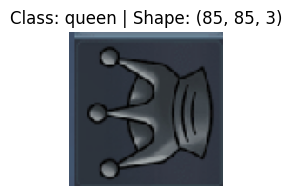

In [19]:
# Get a random image path.
random_img_path = random.choice(img_path_list)

# Get an images class from path name
image_class = random_img_path.parent.stem

# View the image
img = Image.open(random_img_path)
img_as_array = np.asarray(img)
plt.figure(figsize=(2,2))
plt.imshow(img_as_array)
plt.title(f'Class: {image_class} | Shape: {img_as_array.shape}')
plt.axis(False);

# **Apply transforms and batch data.**








In [75]:
data_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(train_path,
                                  transform=data_transform,
                                  target_transform=None)

val_data = datasets.ImageFolder(val_path,
                                transform=data_transform,
                                target_transform=None)

BATCH_SIZE = 20
CPU_COUNT = os.cpu_count()
CLASS_NAMES = train_data.classes

train_loader = DataLoader(dataset=train_data,
                          batch_size = BATCH_SIZE,
                          num_workers=CPU_COUNT,
                          shuffle=True
)

val_loader = DataLoader(dataset=val_data,
                        batch_size = BATCH_SIZE,
                        num_workers=CPU_COUNT,
                        shuffle=False
)

# **TinyVGG model**

In [21]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*21*21,
                  out_features=output_shape)
    )

  def forward(self, x):
    '''
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x
    '''
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# **torchinfo summary of model's shapes and parameters**

In [ ]:
'''
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[20, 3, 85, 85])
'''

Layer (type:depth-idx)                   Output Shape              Param #
DeeperTinyVGG                            [20, 6]                   --
├─Sequential: 1-1                        [20, 10, 42, 42]          --
│    └─Conv2d: 2-1                       [20, 10, 85, 85]          280
│    └─BatchNorm2d: 2-2                  [20, 10, 85, 85]          20
│    └─ReLU: 2-3                         [20, 10, 85, 85]          --
│    └─Conv2d: 2-4                       [20, 10, 85, 85]          910
│    └─BatchNorm2d: 2-5                  [20, 10, 85, 85]          20
│    └─ReLU: 2-6                         [20, 10, 85, 85]          --
│    └─MaxPool2d: 2-7                    [20, 10, 42, 42]          --
├─Sequential: 1-2                        [20, 10, 21, 21]          --
│    └─Conv2d: 2-8                       [20, 10, 42, 42]          910
│    └─BatchNorm2d: 2-9                  [20, 10, 42, 42]          20
│    └─ReLU: 2-10                        [20, 10, 42, 42]          --
│    └─Conv2

# **Training and validation *step* functions**

In [22]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [23]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = device):

  model.eval()

  val_loss, val_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      val_pred = model(X)

      loss = loss_fn(val_pred, y)
      val_loss += loss.item()

      val_class = val_pred.argmax(dim=1)
      val_acc += (val_class == y).sum().item() / len(val_pred)

  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc

# **Training function**

In [24]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  results = {'train_loss': [],
             'train_acc': [],
             'val_loss': [],
             'val_acc': []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    val_loss, val_acc = val_step(model = model,
                                 dataloader = val_dataloader,
                                 loss_fn = loss_fn,
                                 device = device)

    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)

  return results

# **Actually training and evaluating model_0**

In [34]:
NUM_CLASSES = 6
NUM_EPOCHS = 30

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

start_time = timer()
model_0_results = train(model = model_0,
                        train_dataloader = train_loader,
                        val_dataloader = val_loader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
end_time = timer()

print(f'Training time: {end_time - start_time:.4f} seconds')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.7662 | Train Acc: 0.2076 | Val Loss: 1.7551 | Val Acc: 0.2375
Epoch: 1 | Train Loss: 1.7576 | Train Acc: 0.2045 | Val Loss: 1.7514 | Val Acc: 0.2375
Epoch: 2 | Train Loss: 1.7503 | Train Acc: 0.2561 | Val Loss: 1.7429 | Val Acc: 0.2375
Epoch: 3 | Train Loss: 1.6921 | Train Acc: 0.3015 | Val Loss: 1.5857 | Val Acc: 0.4042
Epoch: 4 | Train Loss: 1.2145 | Train Acc: 0.5303 | Val Loss: 0.9084 | Val Acc: 0.7306
Epoch: 5 | Train Loss: 0.7144 | Train Acc: 0.7470 | Val Loss: 0.7316 | Val Acc: 0.7472
Epoch: 6 | Train Loss: 0.4552 | Train Acc: 0.8394 | Val Loss: 0.7050 | Val Acc: 0.8222
Epoch: 7 | Train Loss: 0.3136 | Train Acc: 0.8909 | Val Loss: 0.7218 | Val Acc: 0.7944
Epoch: 8 | Train Loss: 0.1949 | Train Acc: 0.9439 | Val Loss: 0.7969 | Val Acc: 0.8472
Epoch: 9 | Train Loss: 0.1076 | Train Acc: 0.9727 | Val Loss: 0.9909 | Val Acc: 0.8194
Epoch: 10 | Train Loss: 0.0652 | Train Acc: 0.9848 | Val Loss: 1.0697 | Val Acc: 0.8347
Epoch: 11 | Train Loss: 0.0630 | Train Acc

# **Function to plot loss and accuracy**

In [31]:
def loss_curve(results):
  train_loss_res = results['train_loss']
  val_loss_res = results['val_loss']

  train_acc_res = results['train_acc']
  val_acc_res = results['val_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize = (15, 7))

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss_res, label = 'Training Loss')
  plt.plot(epochs, val_loss_res, label = 'Validation Loss')
  plt.title('Loss Curve')
  plt.xlabel('Epochs')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc_res, label = 'Training Accuracy')
  plt.plot(epochs, val_acc_res, label = 'Validation Accuracy')
  plt.title('Accuracy Curve')
  plt.xlabel('Epochs')
  plt.legend()

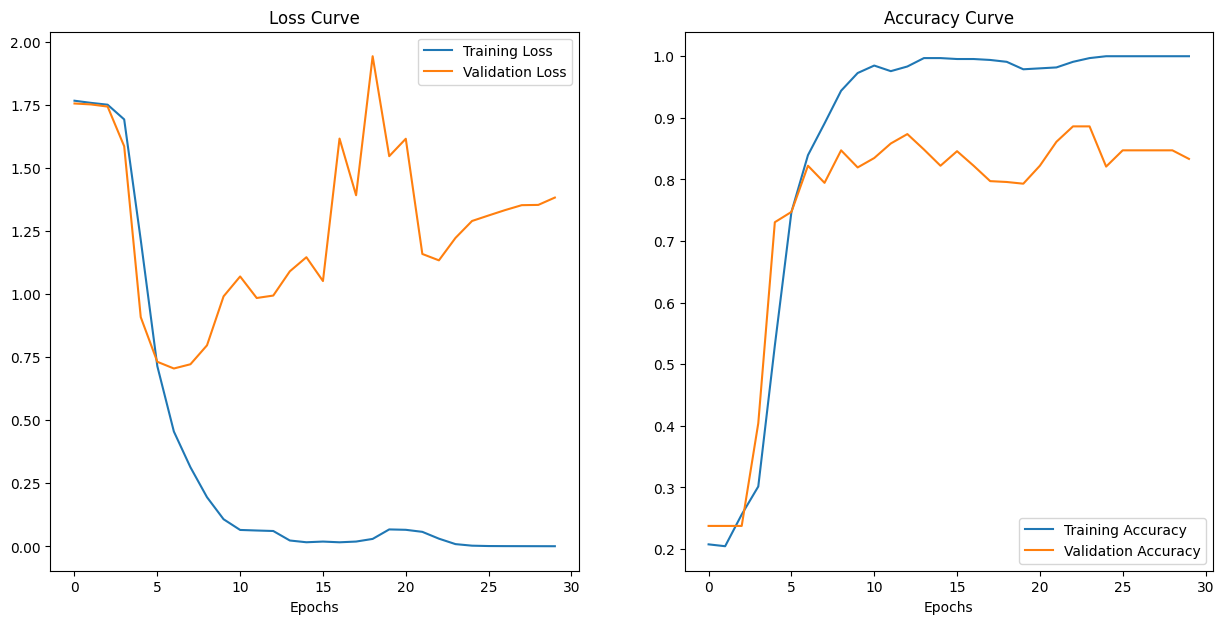

In [36]:
loss_curve(model_0_results)

# **model_1**

In [25]:
data_transform_aug = v2.Compose([
    v2.ColorJitter(),
    v2.RandomGrayscale(p = 0.1),
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, 0.5)),
    v2.RandomHorizontalFlip(p = 0.4),
    v2.RandomVerticalFlip(p = 0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data_aug = datasets.ImageFolder(train_path,
                                      transform=data_transform_aug,
                                      target_transform=None)

val_data_aug = datasets.ImageFolder(val_path,
                                    transform=data_transform,
                                    target_transform=None)

train_loader_aug = DataLoader(dataset=train_data_aug,
                              batch_size = BATCH_SIZE,
                              num_workers=CPU_COUNT,
                              shuffle=True
)

val_loader_aug = DataLoader(dataset=val_data_aug,
                            batch_size = BATCH_SIZE,
                            num_workers=CPU_COUNT,
                            shuffle=False
)

In [35]:
NUM_CLASSES = 6
NUM_EPOCHS = 30

model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

start_time = timer()
model_1_results = train(model = model_1,
                        train_dataloader = train_loader_aug,
                        val_dataloader = val_loader_aug,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
end_time = timer()

print(f'Training time: {end_time - start_time:.4f} seconds')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.7709 | Train Acc: 0.2273 | Val Loss: 1.7583 | Val Acc: 0.2375
Epoch: 1 | Train Loss: 1.7617 | Train Acc: 0.2439 | Val Loss: 1.7499 | Val Acc: 0.2375
Epoch: 2 | Train Loss: 1.7381 | Train Acc: 0.2606 | Val Loss: 1.6880 | Val Acc: 0.2375
Epoch: 3 | Train Loss: 1.3976 | Train Acc: 0.4545 | Val Loss: 1.0352 | Val Acc: 0.6569
Epoch: 4 | Train Loss: 0.9944 | Train Acc: 0.6409 | Val Loss: 1.2326 | Val Acc: 0.6611
Epoch: 5 | Train Loss: 0.9511 | Train Acc: 0.6455 | Val Loss: 0.9154 | Val Acc: 0.7042
Epoch: 6 | Train Loss: 0.8656 | Train Acc: 0.6939 | Val Loss: 0.8649 | Val Acc: 0.7708
Epoch: 7 | Train Loss: 0.7399 | Train Acc: 0.7409 | Val Loss: 0.8546 | Val Acc: 0.7708
Epoch: 8 | Train Loss: 0.7829 | Train Acc: 0.7152 | Val Loss: 0.7768 | Val Acc: 0.7444
Epoch: 9 | Train Loss: 0.6624 | Train Acc: 0.7576 | Val Loss: 0.7687 | Val Acc: 0.7833
Epoch: 10 | Train Loss: 0.7029 | Train Acc: 0.7439 | Val Loss: 0.7016 | Val Acc: 0.7958
Epoch: 11 | Train Loss: 0.6589 | Train Acc

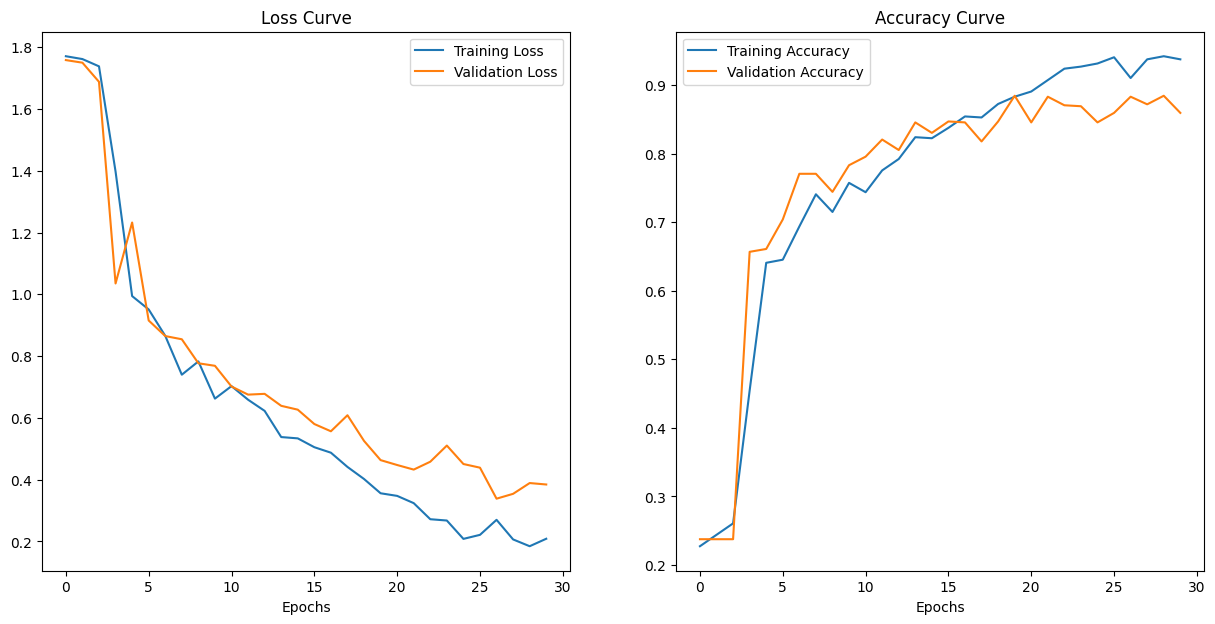

In [37]:
loss_curve(model_1_results)

# **model_2**

In [26]:
class DeeperTinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    '''
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    '''
    self.classifier = nn.Sequential(
        #nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*10*10,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [28]:
NUM_CLASSES = 6
NUM_EPOCHS = 50

model_2 = DeeperTinyVGG(input_shape = 3,
                        hidden_units = 10,
                        output_shape = NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

start_time = timer()
model_2_results = train(model = model_2,
                        train_dataloader = train_loader_aug,
                        val_dataloader = val_loader_aug,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
end_time = timer()

print(f'Training time: {end_time - start_time:.4f} seconds')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.7055 | Train Acc: 0.3242 | Val Loss: 1.8245 | Val Acc: 0.3056
Epoch: 1 | Train Loss: 1.2697 | Train Acc: 0.5576 | Val Loss: 1.0216 | Val Acc: 0.6542
Epoch: 2 | Train Loss: 0.9635 | Train Acc: 0.6848 | Val Loss: 0.7974 | Val Acc: 0.7736
Epoch: 3 | Train Loss: 0.7919 | Train Acc: 0.7333 | Val Loss: 0.6877 | Val Acc: 0.7347
Epoch: 4 | Train Loss: 0.7095 | Train Acc: 0.7712 | Val Loss: 0.6099 | Val Acc: 0.8347
Epoch: 5 | Train Loss: 0.6518 | Train Acc: 0.7773 | Val Loss: 0.5788 | Val Acc: 0.7444
Epoch: 6 | Train Loss: 0.5832 | Train Acc: 0.8045 | Val Loss: 0.5605 | Val Acc: 0.8361
Epoch: 7 | Train Loss: 0.5217 | Train Acc: 0.8364 | Val Loss: 0.4549 | Val Acc: 0.8597
Epoch: 8 | Train Loss: 0.4567 | Train Acc: 0.8424 | Val Loss: 0.4113 | Val Acc: 0.8500
Epoch: 9 | Train Loss: 0.4483 | Train Acc: 0.8439 | Val Loss: 0.4210 | Val Acc: 0.8347
Epoch: 10 | Train Loss: 0.4204 | Train Acc: 0.8591 | Val Loss: 0.3966 | Val Acc: 0.8472
Epoch: 11 | Train Loss: 0.3803 | Train Acc

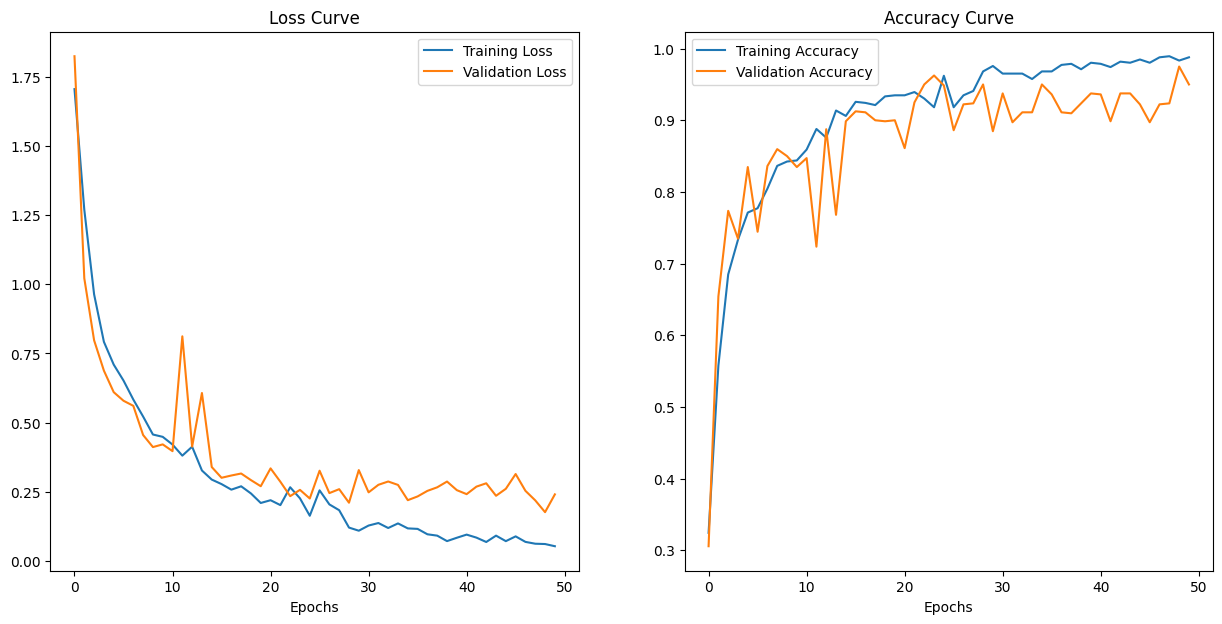

In [32]:
loss_curve(model_2_results)

# **Compare all models**

In [38]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)

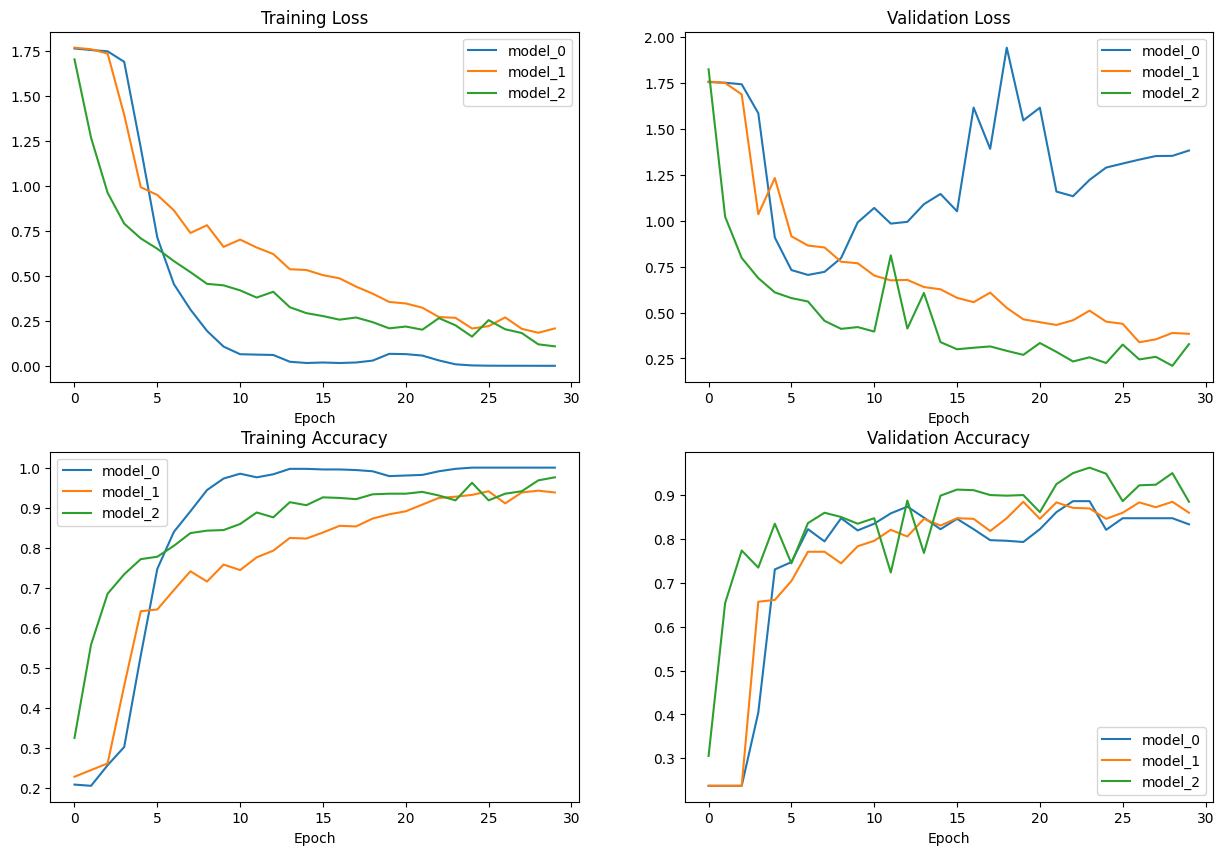

In [52]:
plt.figure(figsize = (15, 10))

epochs = range(len(model_0_df))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label = 'model_0')
plt.plot(epochs, model_1_df['train_loss'], label = 'model_1')
plt.plot(epochs, model_2_df[0:30]['train_loss'], label = 'model_2')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['val_loss'], label = 'model_0')
plt.plot(epochs, model_1_df['val_loss'], label = 'model_1')
plt.plot(epochs, model_2_df[0:30]['val_loss'], label = 'model_2')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label = 'model_0')
plt.plot(epochs, model_1_df['train_acc'], label = 'model_1')
plt.plot(epochs, model_2_df[0:30]['train_acc'], label = 'model_2')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['val_acc'], label = 'model_0')
plt.plot(epochs, model_1_df['val_acc'], label = 'model_1')
plt.plot(epochs, model_2_df[0:30]['val_acc'], label = 'model_2')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

# **Save models**

In [53]:
MODEL_0_NAME = 'model_0_saved.pt'
MODEL_0_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/saved_models') / MODEL_0_NAME
torch.save(obj = model_0.state_dict(), f = MODEL_0_PATH)

In [54]:
MODEL_1_NAME = 'model_1_saved.pt'
MODEL_1_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/saved_models') / MODEL_1_NAME
torch.save(obj = model_1.state_dict(), f = MODEL_1_PATH)

In [55]:
MODEL_2_NAME = 'model_2_saved.pt'
MODEL_2_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/saved_models') / MODEL_2_NAME
torch.save(obj = model_2.state_dict(), f = MODEL_2_PATH)

# **Predict on "real-world" data with trained model**

In [100]:
def predict_and_plot(model: torch.nn.Module,
                     image_path: str,
                     class_names,
                     transforms = None,
                     device = device):

  test_image = torchvision.io.read_image(image_path).type(torch.float32) / 255.

  if transforms:
    test_image = transforms(test_image)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    test_image_pred = model(test_image.unsqueeze(0).to(device))

  test_image_pred_probs = torch.softmax(test_image_pred, dim = 1)

  test_image_pred_label = torch.argmax(test_image_pred_probs, dim = 1)

  plt.imshow(test_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f'Prediction: {class_names[test_image_pred_label.cpu()]} | Probability: {(test_image_pred_probs*100).max().cpu():.2f}%'
  else:
    title = f'Prediction: {test_image_pred_label} | Probability: {(test_image_pred_probs*100).max().cpu():.2f}%'
  plt.title(title)
  plt.axis(False)

In [120]:
test_image_path = '/content/drive/MyDrive/Colab Notebooks/Chess_Piece_Image_Classifier_Digital_Pytorch/split_data/test/queen/192r.png'

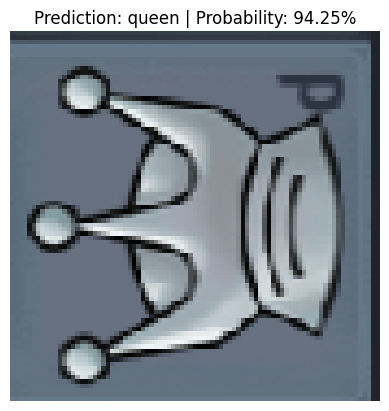

In [121]:
predict_and_plot(model = model_2,
                 image_path = test_image_path,
                 class_names = CLASS_NAMES,
                 transforms = None,
                 device = device)